### Statastical & Machine Learning Indivisual Assignment
<br/>
IESEG School of Management
<br/>
MSc in Big Data Analytics for Business

##### Data processing and ML pipeline templete used in this notebook are based on the notebook shared by Minh Phan - IESEG School of Management
Refference for conditions and encoding functions - Minh Phan (Based on the ML pipeline templete)
<br/>
For code and model references please refer to the last page of the report submitted with this notebook

In [1]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.model_selection import train_test_split


# Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import learning_curve

CPU times: total: 2.55 s
Wall time: 2.96 s


In [2]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

CPU times: total: 0 ns
Wall time: 0 ns


## 1. Data summary

In [116]:
#set working directory
%cd "C:/Users/irana/OneDrive - IESEG/Documents/GitHub/Statastical_Learning/data/raw"

C:\Users\irana\OneDrive - IESEG\Documents\GitHub\Statastical_Learning\data\raw


In [4]:
%%time
# data
data = pd.read_csv('bank_mkt_train.csv', low_memory=False)

CPU times: total: 93.8 ms
Wall time: 83.7 ms


In [5]:
%%time
# Print data
print(data.dtypes.value_counts())
data.head()

object     10
float64     9
int64       2
dtype: int64
CPU times: total: 0 ns
Wall time: 3 ms


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [6]:
%%time
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in data.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

CPU times: total: 0 ns
Wall time: 0 ns


#### (c) Check the target variable class distribution

In [7]:
%%time
# By number
print(data[target_var].value_counts())

# By percentage
print(data[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64
CPU times: total: 31.2 ms
Wall time: 36 ms


## 2. Processing data

#### (a) Check and correct data error - Constant variables

In [8]:
%%time
# Check missing value
print('Data - # NA of num vars:', data[num_vars].isna().sum().sum())

Data - # NA of num vars: 1730
CPU times: total: 31.2 ms
Wall time: 3 ms


In [9]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = data[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = data[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
data = data[id_var + num_vars + cat_vars + target_var]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
CPU times: total: 15.6 ms
Wall time: 24.7 ms


In [10]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(data[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
data[impute_vars] = pd.DataFrame(imp.transform(data[num_vars]), columns=impute_vars)

CPU times: total: 15.6 ms
Wall time: 29 ms


In [12]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
data[cat_vars] = data[cat_vars].fillna('Missing')

CPU times: total: 15.6 ms
Wall time: 18 ms


#### (c) Check and correct data error - Outliers in numerical variables

In [13]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(data[v])
    sd = np.std(data[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    data_out = (data[v] < lower) | (data[v] > upper)
    if np.sum(data_out)  > 0:
        print(v, "has # outliers on train, test :",
              np.sum(data_out), "[", np.round(100*np.mean(data_out), 2), "% ]")

age has # outliers on train, test : 181 [ 0.9 % ]
campaign has # outliers on train, test : 423 [ 2.11 % ]
pdays has # outliers on train, test : 750 [ 3.75 % ]
previous has # outliers on train, test : 519 [ 2.6 % ]
CPU times: total: 31.2 ms
Wall time: 29.7 ms


#### (d) Encode categorical variables

In [14]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([data[cat_vars].astype(str), data[cat_vars].astype(str)], axis=0))
data[cat_vars] = enc.transform(data[cat_vars].astype(str))

CPU times: total: 109 ms
Wall time: 114 ms


#### (e) Finalize the processed data

In [15]:
data.columns

Index(['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job',
       'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'subscribe', 'age_na',
       'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na',
       'cons.price.idx_na', 'cons.conf.idx_na', 'euribor3m_na',
       'nr.employed_na'],
      dtype='object')

In [16]:
%%time
# Convert bool variable to int
data[na_vars] = data[na_vars].astype(np.int8)

CPU times: total: 31.2 ms
Wall time: 29 ms


In [17]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']
CPU times: total: 0 ns
Wall time: 996 µs


In [18]:
%%time
# Sort the data according to the variables list
data = data[id_var + num_vars + cat_vars + na_vars + target_var]
print(data.shape)

(20000, 30)
CPU times: total: 15.6 ms
Wall time: 6.2 ms


In [19]:
data.columns

Index(['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job',
       'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age_na', 'campaign_na', 'pdays_na',
       'previous_na', 'emp.var.rate_na', 'cons.price.idx_na',
       'cons.conf.idx_na', 'euribor3m_na', 'nr.employed_na', 'subscribe'],
      dtype='object')

In [20]:
#create train test split
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data.subscribe)

In [21]:
train = train.reset_index()
test = test.reset_index()

In [22]:
print("Train Shape: ",train.shape, "| Test Shape: ", test.shape)

Train Shape:  (16000, 31) | Test Shape:  (4000, 31)


### 2.2. Feature engineering

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [23]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.240117
cons.conf.idx    0.052097
age              0.034762
Name: subscribe, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.132588
emp.var.rate     -0.299462
euribor3m        -0.310996
pdays            -0.335400
nr.employed      -0.360325
Name: subscribe, dtype: float64
CPU times: total: 15.6 ms
Wall time: 12 ms


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [24]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
poutcome       0.036125
month          0.026625
contact        0.013131
job            0.009433
default        0.007483
marital        0.005475
education      0.000826
housing        0.000356
day_of_week    0.000255
loan           0.000056
dtype: float64
CPU times: total: 812 ms
Wall time: 861 ms


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [25]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49143272622017353 --> 0.6007377603416612


C:\tools\Anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: total: 6.05 s
Wall time: 5.87 s


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization

<u>Note:</u> Some techniques that incoporate the information from target variable may cause overfitting problem.

<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [26]:
%%time
# List of variables to track the value transformation process
trans_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Test the variable remmaping on a categorical variable

In [27]:
%%time
# Select a cat variable
v = "month"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6469725054163981
Best params: {'min_samples_leaf': 160}
Number of leaves: 10
CPU times: total: 109 ms
Wall time: 203 ms


In [28]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories:", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 11
# new remapped categories: 10 {5, 6, 8, 10, 11, 12, 14, 15, 17, 18}
CPU times: total: 141 ms
Wall time: 131 ms


#### (b) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [29]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 13 to 11 categories
Remapping variable marital from 5 to 3 categories
Remapping variable education from 9 to 6 categories
Remapping variable default from 4 to 3 categories
Remapping variable housing from 4 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 10 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories
CPU times: total: 1.86 s
Wall time: 2.38 s


In [30]:
%%time
# Select a num variable
v = "previous"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.6123374926236527
Best params: {'min_samples_leaf': 160}
Number of leaves: 4
CPU times: total: 125 ms
Wall time: 131 ms


In [31]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 6.0]
# new remapped categories: 4 {3, 4, 5, 6}
CPU times: total: 125 ms
Wall time: 117 ms


In [32]:
train.isna().sum().sum()

0

In [33]:
train[train.isna()==True].columns

Index(['index', 'client_id', 'age', 'campaign', 'pdays', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_na',
       'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na',
       'cons.price.idx_na', 'cons.conf.idx_na', 'euribor3m_na',
       'nr.employed_na', 'subscribe', 'age^2', 'age^3', 'job_remap',
       'marital_remap', 'education_remap', 'default_remap', 'housing_remap',
       'contact_remap', 'month_remap', 'day_of_week_remap', 'poutcome_remap'],
      dtype='object')

In [34]:
#Fill na's with mean
train["age^2"] = train.fillna(train["age^2"].mean())
train["age^3"] = train.fillna(train["age^3"].mean())

#for test
test["age^2"] = test.fillna(test["age^2"].mean())
test["age^3"] = test.fillna(test["age^3"].mean())

In [35]:
print(train.subscribe.isna().sum(),
test.subscribe.isna().sum())

0 0


In [36]:
# Apply the variable discretizing for all numerical variables

%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

CPU times: total: 0 ns
Wall time: 1 ms
Discretize variable age from [18.0, 95.0] to 39 categories
Discretize variable campaign from [1.0, 56.0] to 7 categories
Discretize variable pdays from [0.0, 999.0] to 3 categories
Discretize variable previous from [0.0, 6.0] to 4 categories
Discretize variable emp.var.rate from [-3.4, 1.4] to 8 categories
Discretize variable cons.price.idx from [92.201, 94.767] to 14 categories
Discretize variable cons.conf.idx from [-50.8, -26.9] to 15 categories
Discretize variable euribor3m from [0.634, 5.045] to 47 categories
Discretize variable nr.employed from [4963.6, 5228.1] to 9 categories
Discretize variable age^2 from [0.0, 19999.0] to 30 categories
Discretize variable age^3 from [0.0, 19999.0] to 30 categories


In [37]:
# Discretizing (or binning) numerical variables - Equal frequency discretization

In [38]:
#Test the variable discretizing on a numerical variable
%time
# Select a num variable
v = "age"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

CPU times: total: 0 ns
Wall time: 0 ns
Number of bins : 10


array([array([18., 28., 31., 33., 36., 38., 41., 45., 49., 55., 95.])],
      dtype=object)

In [39]:
%%time
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

CPU times: total: 0 ns
Wall time: 4.79 ms


0.0    1232
1.0    1593
2.0    1428
3.0    2052
4.0    1287
5.0    1675
6.0    1731
7.0    1542
8.0    1838
9.0    1622
dtype: int64

In [40]:
import shutup
shutup.please()
#Apply the variable discretizing for all numerical variables
%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.3.5. Finalize value transformation


In [41]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 30
CPU times: total: 0 ns
Wall time: 0 ns


In [42]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars + target_var]
print(train.shape)
print(test.shape)

(16000, 62)
(4000, 62)
CPU times: total: 15.6 ms
Wall time: 17 ms


### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding
- Categorical variable: Incidence replacement
- Categorical variable: Weight of Evidence (WoE) conversion

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [43]:
%%time
# Select a cat variable
v = "job"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]], test[[v]]], axis=0))
enc.categories_

CPU times: total: 0 ns
Wall time: 4 ms


[array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])]

In [44]:
print(train.subscribe.isna().sum())

0


In [45]:
%%time
# Transform a categorical variable
dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

CPU times: total: 0 ns
Wall time: 5 ms


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [46]:
%%time

# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

CPU times: total: 141 ms
Wall time: 142 ms


In [47]:
%%time
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

CPU times: total: 172 ms
Wall time: 169 ms


#### 2.4.2. Incidence (of target variable) replacement

In [48]:
#Test the value representation on a categorical variable

In [49]:
%%time
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

CPU times: total: 31.2 ms
Wall time: 9 ms


,job,job_icd
0,0.0,0.105263
1,1.0,0.126347
2,2.0,0.070516
3,3.0,0.091241
4,4.0,0.108235
5,5.0,0.125445
6,6.0,0.254464
7,7.0,0.097518
8,8.0,0.080921
9,9.0,0.313846


In [50]:
%%time
# Add/join the incidence variable
pd.merge(train[[v]], tb, on=v).head()

CPU times: total: 15.6 ms
Wall time: 8 ms


,job,job_icd
0,1.0,0.126347
1,1.0,0.126347
2,1.0,0.126347
3,1.0,0.126347
4,1.0,0.126347


In [51]:
train.age_bin

0        32
1        10
2        30
3         5
4        55
         ..
15995    28
15996    18
15997    32
15998     5
15999    23
Name: age_bin, Length: 16000, dtype: int64

In [52]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

CPU times: total: 1.09 s
Wall time: 1.11 s


#### 2.4.3. Weight-of-Evidence (WoE) conversion

In [53]:
%%time
# Select a variable
v = "job"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

CPU times: total: 15.6 ms
Wall time: 15.7 ms


subscribe,job,0,1,job_woe
0,0.0,119,14,-2.140066
1,1.0,3485,504,-1.933647
2,2.0,3348,254,-2.578784
3,3.0,498,50,-2.298577
4,4.0,379,46,-2.108895
5,5.0,983,141,-1.941849
6,6.0,501,171,-1.074943
7,7.0,509,55,-2.225115
8,8.0,1397,123,-2.429898
9,9.0,223,102,-0.782199


In [54]:
%%time
# Add/join the WoE variable
pd.merge(train[[v]], tb[[v, v + "_woe"]], on=v).head()

CPU times: total: 31.2 ms
Wall time: 10.2 ms


,job,job_woe
0,1.0,-1.933647
1,1.0,-1.933647
2,1.0,-1.933647
3,1.0,-1.933647
4,1.0,-1.933647


#### (b) Apply the value representation for all categorical variables

In [55]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

CPU times: total: 953 ms
Wall time: 967 ms


#### 2.4.3. Finalize value representation 

In [56]:
print(train.subscribe.isna().sum())
print(test.subscribe.isna().sum())

0
0


In [57]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

CPU times: total: 62.5 ms
Wall time: 30.9 ms


In [58]:
print(train.subscribe.isna().sum())

0


In [59]:
train.index

RangeIndex(start=0, stop=16000, step=1)

In [60]:
train_dummy.shape

(16000, 345)

In [61]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

CPU times: total: 78.1 ms
Wall time: 84.5 ms


#### (b) Impute missing values created by value representation

During the value representation process, if the categorical variables have new categories on test, the represented values might be missing on test data. Therefore, it is necessary to correct again here.

In [62]:
print(train.subscribe.isna().sum())

0


In [63]:
print(train.columns)

Index(['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       ...
       'x38_9.0', 'x39_1.0', 'x39_2.0', 'x39_3.0', 'x39_4.0', 'x39_5.0',
       'x39_6.0', 'x39_7.0', 'x39_8.0', 'x39_9.0'],
      dtype='object', length=447)


In [64]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

CPU times: total: 688 ms
Wall time: 650 ms


In [65]:
test[repr_vars].shape

(4000, 770)

In [66]:
len(repr_vars)

770

#### (c) Finalize the variables list


In [67]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 770
CPU times: total: 0 ns
Wall time: 0 ns


In [68]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars + target_var]
print(train.shape)
print(test.shape)

(16000, 792)
(4000, 792)
CPU times: total: 46.9 ms
Wall time: 45.5 ms


In [69]:
##### (a) Data normalization - Numerical variables
%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


In [70]:
#####  (b) Filter out low variance variables (or constant)
%time

# List of all predictors
predictors = num_vars + cat_vars + na_vars

CPU times: total: 0 ns
Wall time: 0 ns


In [71]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
CPU times: total: 453 ms
Wall time: 456 ms


In [72]:
# drop duplicates
%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

CPU times: total: 0 ns
Wall time: 0 ns
# duplicated vars : 1118


In [73]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors + target_var]

CPU times: total: 31.2 ms
Wall time: 32.5 ms


In [74]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(16000, 556)
(4000, 556)
CPU times: total: 0 ns
Wall time: 0 ns


In [118]:
base_table = pd.concat([train, test]).reset_index(drop=True)
data.to_csv("../interm/base_table_without_feature_eng.csv")
base_table.to_csv("../interm/base_table_with_feature_eng.csv")

### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [75]:
%%time
# Create several lists to handle variables
id_var = ['client_id']
target_var = ['subscribe']
predictors = [v for v in train.columns if v not in id_var + target_var]

CPU times: total: 0 ns
Wall time: 1.04 ms


In [76]:
%%time

#Fisher Score
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
pd.set_option('display.max_rows', 100)

In [78]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df["fisherscore2"] = fs_df.fisherscore.astype(str).str.extract(r' (.*)')
fs_df["fisher_merged"] = np.where(fs_df.fisherscore2.isna(),fs_df.fisherscore, fs_df.fisherscore2)
fs_df = fs_df.drop(["fisherscore2", "fisherscore"], axis=1)
fs_df.columns = ["predictor", "fisherscore"]
fs_df.fisherscore = fs_df.fisherscore.astype(float)
fs_df.head(10)

CPU times: total: 5.95 s
Wall time: 6.24 s


,predictor,fisherscore
0,age,0.066908
1,campaign,0.171527
2,pdays,0.468190
3,previous,0.392902
4,emp.var.rate,0.670625
5,cons.price.idx,0.274144
6,cons.conf.idx,0.100717
7,euribor3m,0.706631
8,nr.employed,0.747912
9,age^2,0.035448


In [79]:
fs_df = fs_df.sort_values('fisherscore', ascending=False).reset_index(drop=True)
fs_df.head()

,predictor,fisherscore
0,nr.employed,0.747912
1,euribor3m,0.706631
2,emp.var.rate,0.670625
3,x33_4.0,0.597664
4,x33_4.0,0.597664


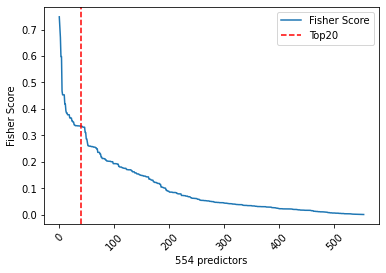

CPU times: total: 203 ms
Wall time: 184 ms


In [80]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=40, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

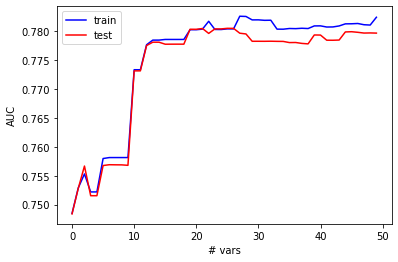

CPU times: total: 1.28 s
Wall time: 25.2 s


In [81]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [82]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 35  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 35
CPU times: total: 0 ns
Wall time: 0 ns


array(['nr.employed', 'euribor3m', 'emp.var.rate', 'x33_4.0', 'x33_4.0',
       'pdays', 'x9_3.0', 'x9_3.0', 'x18_4', 'x18_4', 'x37_4.0',
       'x37_4.0', 'previous', 'x32_1.0', 'x32_1.0', 'x18_3', 'x18_3',
       'x9_2.0', 'x9_2.0', 'x23_14', 'x23_14', 'x27_16', 'x27_16',
       'x33_2.0', 'x33_2.0', 'x21_3', 'x21_3', 'x24_21', 'x24_21',
       'x15_4', 'x6_2.0', 'x6_2.0', 'x15_4', 'x27_13', 'x27_13'],
      dtype=object)

#### Corelation based feature selection

In [83]:
%time
p_x = ['client_id', 'age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job',
       'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age_na', 'campaign_na', 'pdays_na',
       'previous_na', 'emp.var.rate_na', 'cons.price.idx_na',
       'cons.conf.idx_na', 'euribor3m_na', 'nr.employed_na']

p_y = 'subscribe'

CPU times: total: 0 ns
Wall time: 0 ns


In [84]:
%time
#Get corelation based on Kendall, Pearson and Spearman's score
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

CPU times: total: 0 ns
Wall time: 0 ns


In [85]:
%time
corr_p = train.corr(method=pearsonr_pval)
corr_s = train.corr(method=spearmanr_pval)
corr_k = train.corr(method=kendall_pval) 

CPU times: total: 0 ns
Wall time: 0 ns


In [86]:
%time
#Get top variables based on the cutoff of 80%
cutoff = .8
cp_cols = corr_p[corr_p["subscribe"]>cutoff].index
cs_cols = corr_s[corr_s["subscribe"]>cutoff].index
ck_cols = corr_k[corr_k["subscribe"]>cutoff].index

CPU times: total: 0 ns
Wall time: 0 ns


In [87]:
%time
cor_cols = list(set(cp_cols) & set(cs_cols) & set(ck_cols))
cor_cols.remove('subscribe')
print(len(cor_cols))

p_f_cols = list(top_fs_vars) + cor_cols

CPU times: total: 0 ns
Wall time: 0 ns
18


## Modeling

#### First we get bechmark by running the models with all predictors with default model parametres

In [88]:
logistic     = LogisticRegression()
DT           = DecisionTreeClassifier()
randomForest = RandomForestClassifier()
SGD          = CalibratedClassifierCV(SGDClassifier(loss='squared_error'))
ADABoost     = AdaBoostClassifier()


# create a dict to loop through the models later on
models = {
          "Logistic Regression"     :logistic,
          "DT"                      :DT,
          "Random Forest"           :randomForest,
          "SGD Classifier"          :SGD,
          "ADABoost"                :ADABoost

         }

In [89]:
train_x_all = train[predictors]
train_y     = train[target_var].values.ravel()


import random
shutup.please()
for model in models:
    %time
    random.seed=42
    models[model].fit(train_x_all, train_y)
    print(f"{model} has been trained successfully")

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
DT has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost has been trained successfully


In [90]:
performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(train_x_all)
    probabilities = pd.DataFrame(models[model].predict_proba(train_x_all))[1]
    accuracy      = accuracy_score(train_y,predictions)
    auc           = roc_auc_score(np.array(train_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Train_Accuracy":accuracy,"Train_AUC":auc}

train_perf = pd.DataFrame(performances).transpose().sort_values(by="Train_AUC", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [91]:
test_x_all = test[predictors]
test_y     = test[target_var].values.ravel()

In [92]:
performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(test_x_all)
    probabilities = pd.DataFrame(models[model].predict_proba(test_x_all))[1]
    accuracy      = accuracy_score(test_y,predictions)
    auc           = roc_auc_score(np.array(test_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Test_Accuracy":accuracy,"Test_AUC":auc}

test_perf = pd.DataFrame(performances).transpose().sort_values(by="Test_AUC", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [93]:
perf_all_vars = train_perf.merge(test_perf, left_index=True, right_index=True)

In [94]:
perf_all_vars

,Train_Accuracy,Train_AUC,Test_Accuracy,Test_AUC
DT,1.000000,1.000000,0.83375,0.635423
Random Forest,0.999875,1.000000,0.89500,0.767675
Logistic Regression,0.904250,0.818633,0.89475,0.780463
ADABoost,0.901500,0.811320,0.89675,0.780094
SGD Classifier,0.886437,0.500000,0.88650,0.500000


### Default parametres with feature selection - Based on Fisher Score

In [95]:
logistic_fisher     = LogisticRegression()
DT_fisher           = DecisionTreeClassifier()
randomForest_fisher = RandomForestClassifier()
SGD_fisher          = CalibratedClassifierCV(SGDClassifier(loss='squared_error'))
ADABoost_fisher     = AdaBoostClassifier()



# create a dict to loop through the models later on
models = {
          "Logistic Regression"     :logistic_fisher,
          "DT"                      :DT_fisher,
          "Random Forest"           :randomForest_fisher,
          "SGD Classifier"          :SGD_fisher,
          "ADABoost"                :ADABoost_fisher

         }

In [96]:
len(top_fs_vars)

35

In [97]:
train_x_fisher = train[top_fs_vars]
train_y     = train[target_var].values.ravel()

import random
shutup.please()
for model in models:
    %time
    random.seed=42
    models[model].fit(train_x_fisher, train_y)
    print(f"{model} has been trained successfully")

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
DT has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost has been trained successfully


In [126]:
%time
texport = train[top_fs_vars]
texport["subscribe"] =  train_y

tsxport = test[top_fs_vars]
tsxport["subscribe"] =  test_y

base_table_feature_sel = pd.concat([texport, tsxport]).reset_index(drop=True)
base_table_feature_sel.to_csv("../processed/base_table_feature_selection.csv")

CPU times: total: 0 ns
Wall time: 0 ns


In [98]:
performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(train_x_fisher)
    probabilities = pd.DataFrame(models[model].predict_proba(train_x_fisher))[1]
    accuracy      = accuracy_score(train_y,predictions)
    auc           = roc_auc_score(np.array(train_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Train_Accuracy_F":accuracy,"Train_AUC_F":auc}

train_perf_fisher = pd.DataFrame(performances).transpose().sort_values(by="Train_AUC_F", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [99]:
test_x_fisher = test[top_fs_vars]
test_y     = test[target_var].values.ravel()


performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(test_x_fisher)
    probabilities = pd.DataFrame(models[model].predict_proba(test_x_fisher))[1]
    accuracy      = accuracy_score(test_y,predictions)
    auc           = roc_auc_score(np.array(test_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Test_Accuracy_F":accuracy,"Test_AUC_F":auc}

test_perf_fisher = pd.DataFrame(performances).transpose().sort_values(by="Test_AUC_F", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [100]:
perf_fisher_vars = train_perf_fisher.merge(test_perf_fisher, left_index=True, right_index=True)
perf_fisher_vars

,Train_Accuracy_F,Train_AUC_F,Test_Accuracy_F,Test_AUC_F
DT,0.923813,0.858448,0.89200,0.693653
Random Forest,0.923813,0.850099,0.89275,0.765196
ADABoost,0.900813,0.798792,0.89725,0.787708
Logistic Regression,0.900250,0.781084,0.89725,0.780051
SGD Classifier,0.900250,0.778267,0.89700,0.771916


In [101]:
all_data = pd.concat([train, test]).reset_index(drop=True)

### Cross Validation on top 2 Models

In [102]:
%time
cv_auc_lr = cross_val_score(logistic_fisher, all_data[top_fs_vars], all_data.subscribe, cv=10, scoring='roc_auc')
print("Mean AUC: ", cv_auc_lr.mean())
cv_auc_lr

CPU times: total: 0 ns
Wall time: 0 ns
Mean AUC:  0.7793632857113336


array([0.80868435, 0.7824278 , 0.77534158, 0.78374218, 0.75972306,
       0.78569263, 0.79413175, 0.74410454, 0.77286562, 0.78691933])

In [103]:
%time
cv_auc_ada = cross_val_score(ADABoost_fisher, all_data[top_fs_vars], all_data.subscribe, cv=15, scoring='roc_auc')
print("mean AUC: ", cv_auc_ada.mean())
cv_auc_ada

CPU times: total: 0 ns
Wall time: 0 ns
mean AUC:  0.7907664186825263


array([0.83355875, 0.78673524, 0.78682151, 0.79625301, 0.796907  ,
       0.80477583, 0.75624713, 0.79713921, 0.79248888, 0.80607288,
       0.79063435, 0.75226353, 0.79686747, 0.77046425, 0.79426724])

#### Run models with combined feature selection based on Fisher's Score and Corelation

In [104]:
%time
logistic_fisher_corr     = LogisticRegression()
DT_fisher_corr           = DecisionTreeClassifier()
randomForest_fisher_corr = RandomForestClassifier()
SGD_fisher_corr         = CalibratedClassifierCV(SGDClassifier(loss='squared_error'))
ADABoost_fisher_corr     = AdaBoostClassifier()



# create a dict to loop through the models later on
models = {
          "Logistic Regression"     :logistic_fisher_corr,
          "DT"                      :DT_fisher_corr,
          "Random Forest"           :randomForest_fisher_corr,
          "SGD Classifier"          :SGD_fisher_corr,
          "ADABoost"                :ADABoost_fisher_corr

         }

CPU times: total: 0 ns
Wall time: 0 ns


In [105]:
train_x_fisher_p = train[p_f_cols]
train_y     = train[target_var].values.ravel()

import random
shutup.please()
for model in models:
    %time
    random.seed=42
    models[model].fit(train_x_fisher_p, train_y)
    print(f"{model} has been trained successfully")

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
DT has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier has been trained successfully
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost has been trained successfully


In [106]:
performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(train_x_fisher_p)
    probabilities = pd.DataFrame(models[model].predict_proba(train_x_fisher_p))[1]
    accuracy      = accuracy_score(train_y,predictions)
    auc           = roc_auc_score(np.array(train_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Train_Accuracy_FP":accuracy,"Train_AUC_FP":auc}

train_perf_fisher_p = pd.DataFrame(performances).transpose().sort_values(by="Train_AUC_FP", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [107]:
test_x_fisher_p = test[p_f_cols]
test_y     = test[target_var].values.ravel()


performances = {}

for model in models:
    %time
    random.seed=42
    predictions   = models[model].predict(test_x_fisher_p)
    probabilities = pd.DataFrame(models[model].predict_proba(test_x_fisher_p))[1]
    accuracy      = accuracy_score(test_y,predictions)
    auc           = roc_auc_score(np.array(test_y),np.array(probabilities))
    print(f"{model} completed.")
    
    performances[model] = {"Test_Accuracy_FP":accuracy,"Test_AUC_FP":auc}

test_perf_fisher_p = pd.DataFrame(performances).transpose().sort_values(by="Test_AUC_FP", ascending=False)

CPU times: total: 0 ns
Wall time: 0 ns
Logistic Regression completed.
CPU times: total: 0 ns
Wall time: 0 ns
DT completed.
CPU times: total: 0 ns
Wall time: 0 ns
Random Forest completed.
CPU times: total: 0 ns
Wall time: 0 ns
SGD Classifier completed.
CPU times: total: 0 ns
Wall time: 0 ns
ADABoost completed.


In [108]:
perf_fisher_corr_vars  = train_perf_fisher_p.merge(test_perf_fisher_p, left_index=True, right_index=True)
perf_fisher_corr_vars

,Train_Accuracy_FP,Train_AUC_FP,Test_Accuracy_FP,Test_AUC_FP
DT,0.940438,0.931265,0.88150,0.632255
Random Forest,0.940375,0.918136,0.88425,0.737800
ADABoost,0.901000,0.798024,0.89800,0.787114
Logistic Regression,0.900250,0.784316,0.89825,0.781717
SGD Classifier,0.886437,0.771814,0.88650,0.773814


### Combine evaluation tables and transform table to make it easy to read

In [109]:
All_Perf = perf_fisher_vars.merge(perf_all_vars, left_index=True, right_index=True).merge(perf_fisher_corr_vars, left_index=True, right_index=True)

In [110]:
All_Perf = All_Perf[['Train_Accuracy', 'Test_Accuracy', 'Train_AUC', 'Test_AUC',
'Train_Accuracy_F', 'Test_Accuracy_F','Train_AUC_F',  'Test_AUC_F',
       'Train_Accuracy_FP', 'Test_Accuracy_FP', 'Train_AUC_FP',  'Test_AUC_FP']]

All_Perf.columns = ['Train_Accuracy_All_Features', 'Test_Accuracy_All_Features', 'Train_AUC_All_Features', 'Test_AUC_All_Features',
'Train_Accuracy_Fisher_Score', 'Test_Accuracy_Fisher_Score', 'Train_AUC_Fisher_Score',  'Test_AUC_Fisher_Score',
       'Train_Accuracy_Fisher_Corr_Score', 'Test_Accuracy_Fisher_Corr_Score', 'Train_AUC_Fisher_Corr_Score', 'Test_AUC_Fisher_Corr_Score']  

In [111]:
All_Perf_T = All_Perf.T
All_Perf_T

,DT,Random Forest,ADABoost,Logistic Regression,SGD Classifier
Train_Accuracy_All_Features,1.000000,0.999875,0.901500,0.904250,0.886437
Test_Accuracy_All_Features,0.833750,0.895000,0.896750,0.894750,0.886500
Train_AUC_All_Features,1.000000,1.000000,0.811320,0.818633,0.500000
Test_AUC_All_Features,0.635423,0.767675,0.780094,0.780463,0.500000
Train_Accuracy_Fisher_Score,0.923813,0.923813,0.900813,0.900250,0.900250
Test_Accuracy_Fisher_Score,0.892000,0.892750,0.897250,0.897250,0.897000
Train_AUC_Fisher_Score,0.858448,0.850099,0.798792,0.781084,0.778267
Test_AUC_Fisher_Score,0.693653,0.765196,0.787708,0.780051,0.771916
Train_Accuracy_Fisher_Corr_Score,0.940438,0.940375,0.901000,0.900250,0.886437
Test_Accuracy_Fisher_Corr_Score,0.881500,0.884250,0.898000,0.898250,0.886500


In [112]:
AUC_L = ['Train_AUC_All_Features', 'Test_AUC_All_Features','Train_AUC_Fisher_Score', 'Test_AUC_Fisher_Score', 'Train_AUC_Fisher_Corr_Score', 'Test_AUC_Fisher_Corr_Score']
ACCURACY_L = ['Train_Accuracy_All_Features', 'Test_Accuracy_All_Features','Train_Accuracy_Fisher_Score', 'Test_Accuracy_Fisher_Score', 'Train_Accuracy_Fisher_Corr_Score', 'Test_Accuracy_Fisher_Corr_Score']

#### Compare AUC

In [113]:
All_Perf_T[All_Perf_T.index.isin(AUC_L)]

,DT,Random Forest,ADABoost,Logistic Regression,SGD Classifier
Train_AUC_All_Features,1.000000,1.000000,0.811320,0.818633,0.500000
Test_AUC_All_Features,0.635423,0.767675,0.780094,0.780463,0.500000
Train_AUC_Fisher_Score,0.858448,0.850099,0.798792,0.781084,0.778267
Test_AUC_Fisher_Score,0.693653,0.765196,0.787708,0.780051,0.771916
Train_AUC_Fisher_Corr_Score,0.931265,0.918136,0.798024,0.784316,0.771814
Test_AUC_Fisher_Corr_Score,0.632255,0.737800,0.787114,0.781717,0.773814


### Compare Accuracy

In [114]:
All_Perf_T[All_Perf_T.index.isin(ACCURACY_L)]

,DT,Random Forest,ADABoost,Logistic Regression,SGD Classifier
Train_Accuracy_All_Features,1.000000,0.999875,0.901500,0.90425,0.886437
Test_Accuracy_All_Features,0.833750,0.895000,0.896750,0.89475,0.886500
Train_Accuracy_Fisher_Score,0.923813,0.923813,0.900813,0.90025,0.900250
Test_Accuracy_Fisher_Score,0.892000,0.892750,0.897250,0.89725,0.897000
Train_Accuracy_Fisher_Corr_Score,0.940438,0.940375,0.901000,0.90025,0.886437
Test_Accuracy_Fisher_Corr_Score,0.881500,0.884250,0.898000,0.89825,0.886500


In [115]:
# GridSearchCV(estimator=SGD())

Thank you!